# 📄 Knowledge Discovery & Pattern Extraction Exam

In this report, I document my analysis of a murder‐mystery dataset (The Midnight Mystery) using various knowledge discovery and pattern extraction techniques. The goal is to uncover hidden relationships, detect anomalies, and ultimately identify the murderer based on textual interrogations and metadata. You can find the full problem statement in problem.md.

## 📊 1. Data Preparation & Exploratory Analysis

The dataset under investigation contains structured information about a cast of 60 guests, one of whom, Solicitor Gray, has been murdered. Among the metadata are 15 distinct locations within the mansion (such as the cellar, garden, smoking room...), alongside a detailed list of 59 interrogation transcripts. Each transcript includes a guest’s statement indicating their location at the time of the murder, the people they reportedly saw, and a disclaimer regarding any knowledge of a note. This note, however, plays a crucial role in the case.

The victim, Lady Mustard, is said to have written a final note addressed to her killer, which she managed to tear away during the struggle. The note is written in a Scottish dialect and directly confronts the murderer, referencing their insurance debts, past misdeeds, etc. Notably, the note urges the recipient to bring the account books and to stop lying, offering one final opportunity for redemption. This linguistic and contextual evidence becomes central to the investigation.

As part of the preparation process, each guest’s declared location was extracted by scanning their statement and identifying the first token that matched one of the known room names in the mansion. This allowed for the creation of a guest-to-location mapping that reflects where each individual claimed to be at approximately 11:50 PM, the established time of the murder. In parallel, a second mapping was constructed to record who each guest claimed to have seen. This was determined by scanning each statement for mentions of any other guest names, case-insensitively, and recording any matches. Here's the python code:

In [12]:
import json
import re

with open('dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Victim's note text
note_text = data['metadata']['victim_note']
print("Victim's note text:")
print(note_text + "\n")

# List of locations
locations = data['metadata']['locations']
locations = [loc.split()[0] for loc in locations]

# Statement extraction of each guest
interview_texts = {
    entry['guest']: entry['statement']
    for entry in data['interrogations']
}

# Hashmap guest -> location
guest_locations = {}
for guest, stmt in interview_texts.items():
    # Tokenizzo la dichiarazione in singole parole (togliendo punteggiatura)
    tokens = re.findall(r"\b[\w']+\b", stmt.lower())
    found = None
    for word in tokens:
        for loc in locations:
            if word == loc.lower():
                found = loc
                break
        if found:
            break
    guest_locations[guest] = found

# Hashmap guest -> list of seen guests
sightings = {}
all_guests = list(interview_texts.keys())
for guest, stmt in interview_texts.items():
    seen_list = []
    for other in all_guests:
        if other == guest:
            continue
        if other.lower() in stmt.lower():
            seen_list.append(other)
    sightings[guest] = seen_list

print("Hashmap guest -> location:")
for g, loc in guest_locations.items():
    print(f"{g}: {loc}")

print("\nHashmap guest -> list of seen guests:")
for g, seen in sightings.items():
    print(f"{g}: {seen}")

Victim's note text:
Och, Yer carefully constructed life is built on foundations of sand, and the tide is coming in. I hae spoken wi' the witnesses ye thocht were silenced forever. They telt me aboot the fire, aboot who right started it and why. The insurance money that funded yer rise tae prominence - blood money, every penny of it. Ye smile and charm yer way throo society, but I see the darkness behind yer eyes. Tonight, we end this charade. Meet me and face yer past, or I will ensure everyone knows the truth by morning. The choice is yours.

Hashmap guest -> location:
Professor Blackstone: dining
Ambassador Indigo: conservatory
Baron Brown: study
Mister Fitzgerald: conservatory
Commodore White: billiard
Magistrate Ochre: garden
Doctor Scarlett: kitchen
Miss Azure: smoking
Baron Blackwood: study
Counselor Scarlett: garden
Rector Violet: cellar
Barrister Beaumont: lounge
Commodore Ebony: gallery
Baron Sienna: cellar
Magistrate Ruby: lounge
Colonel Ravenswood: hall
Major Beaumont: billi

These two mappings—guest-to-location and guest-to-sightings—form the foundation of the graph representation that follows.

# 💡 2. Visualization of the dataset using graphs

By modeling guests as nodes and sightings as directed edges, it becomes possible to visualize the network of interactions and identify possible inconsistencies or patterns in the accounts, before maybe advancing to community detection or linguistic analysis.

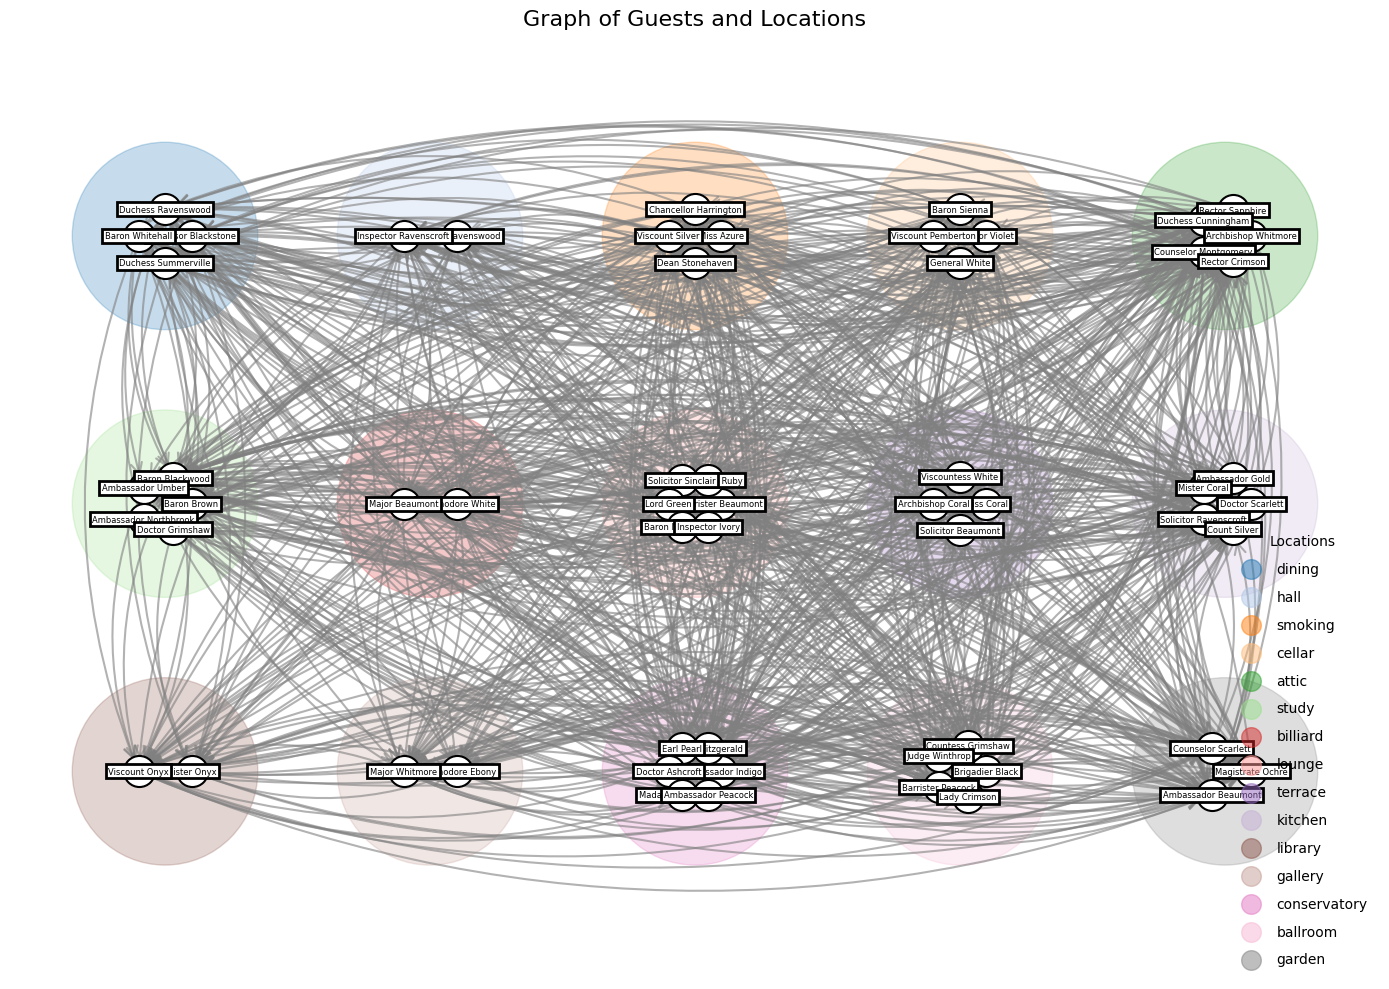

In [13]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

G = nx.DiGraph()
for guest, loc in guest_locations.items():
    G.add_node(guest, location=loc)

for viewer, seen_list in sightings.items():
    for seen in seen_list:
        if seen in G:
            G.add_edge(viewer, seen)

unique_locations = list(set(guest_locations.values()))
scale = 2
location_positions = {loc: (scale * (i % 5), -scale * (i // 5)) for i, loc in enumerate(unique_locations)}
color_map = {loc: plt.cm.tab20(i) for i, loc in enumerate(unique_locations)}

pos = {}
for loc in unique_locations:
    guests_in_loc = [g for g, l in guest_locations.items() if l == loc]
    center = np.array(location_positions[loc])
    angle_step = 2 * np.pi / max(1, len(guests_in_loc))
    radius = 0.2
    for i, guest in enumerate(guests_in_loc):
        angle = i * angle_step
        offset = radius * np.array([np.cos(angle), np.sin(angle)])
        pos[guest] = center + offset

plt.figure(figsize=(14, 10))

for loc, center in location_positions.items():
    guests = [g for g, l in guest_locations.items() if l == loc]
    radius = 0.2 + 0.1 * 5
    circle = Circle(center, radius, color=color_map[loc], alpha=0.25, zorder=0)
    plt.gca().add_patch(circle)

nx.draw_networkx_nodes(G, pos, node_color='white', node_size=500, edgecolors='black', linewidths=1.5)
nx.draw_networkx_edges(G, pos, connectionstyle='arc3,rad=0.2', width=1.5, arrowstyle='->', arrowsize=20, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_color='black', font_size=6, bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2))

for loc, color in color_map.items():
    plt.scatter([], [], c=[color], alpha=0.5, s=200, label=loc)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title="Locations")

plt.title("Graph of Guests and Locations", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

Sadly, due to the density and scale of the resulting graph—where nearly every guest mentions or is mentioned by several others—the visualization alone proves insufficient for drawing reliable conclusions.
The high number of nodes and overlapping directed edges makes it challenging to isolate anomalies or meaningful substructures purely by visual inspection, and for this reason, we shift our focus from visual patterns to the internal structure of each guest’s statement. In particular, we aim to analyze linguistic similarities between the victim’s note and each testimony, as this may reveal stylistic or dialectal clues that point to the true author—and thus, potentially, to the murderer.

# 🔎 3. Statement Analysis using SBERT

To move beyond surface-level textual comparisons and explore deeper stylistic and semantic similarities between the victim’s note and the statements provided by the guests, I employed Sentence-BERT (SBERT), a transformer-based model designed to generate high-quality sentence embeddings. This approach allows us to quantify how linguistically similar each guest’s statement is to the note allegedly written by the murderer.

First, the victim’s note was encoded into a dense vector representation using the paraphrase-MiniLM-L6-v2 SBERT model. Each guest’s statement was similarly encoded, resulting in a fixed-length vector for every text. I then computed the cosine similarity between the note’s embedding and each of the 59 guest statement embeddings. The output was a ranked list of guests, ordered by how closely their writing style and content matched that of the note.

This technique enables us to capture not only lexical overlap but also structural and semantic closeness—offering a powerful alternative to naive keyword matching.

Here's the python code:

/Users/fabbi/Coding/knowledge-extraction/midnight/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/fabbi/Coding/knowledge-extraction/midnight/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/fabbi/Coding/knowledge-extraction/midnight/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


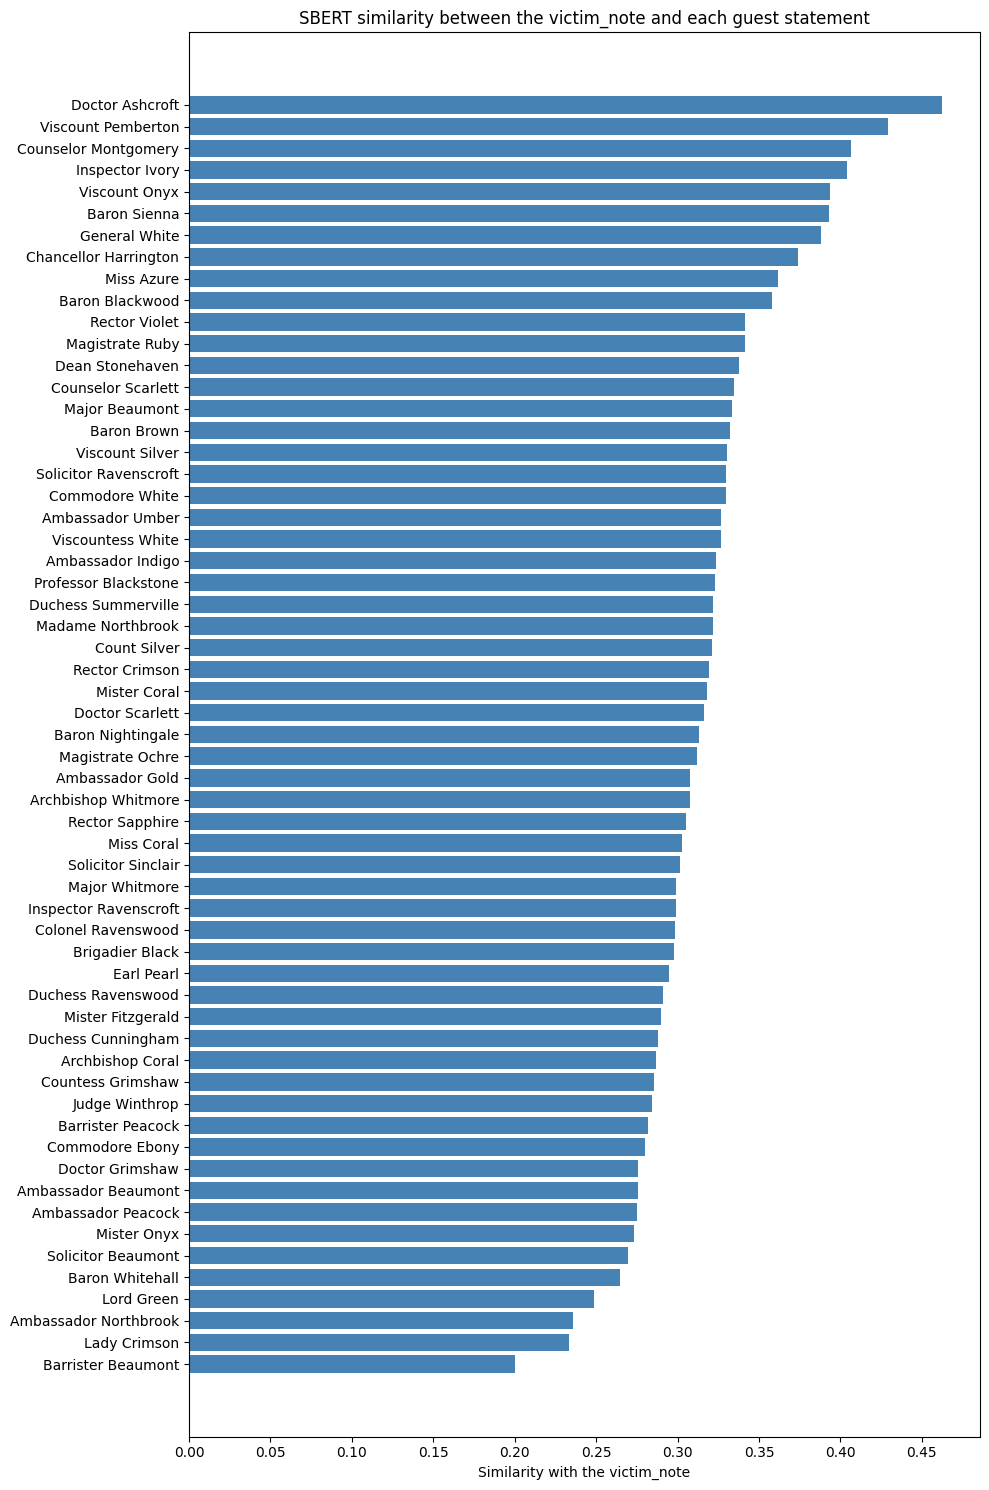

The suggested suspect is Doctor Ashcroft with a similarity score of 0.4626


In [14]:
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# embeddings calculated for the victim's note and each guest's statement
texts = [note_text] + list(interview_texts.values())
embeddings = model.encode(texts)

# cosine similarity calculation between the victim's note (index 0) and each guest's statement (from index 1 onwards)
note_embedding = embeddings[0]
interview_embeddings = embeddings[1:]
similarities = cosine_similarity([note_embedding], interview_embeddings)[0]

# DataFrame creation with guest names and their similarity scores
df_sim = pd.DataFrame({
    "guest": list(interview_texts.keys()),
    "similarity": similarities
}).sort_values(by="similarity", ascending=False).reset_index(drop=True)

# plot the similarity scores
plt.figure(figsize=(10, 15))
guests = df_sim['guest']
scores = df_sim['similarity']

y_pos = np.arange(len(guests))
plt.barh(y_pos, scores, color='steelblue')
plt.yticks(y_pos, guests)
plt.gca().invert_yaxis()  # mette il valore più alto in cima
plt.xlabel("Similarity with the victim_note")
plt.title("SBERT similarity between the victim_note and each guest statement")

# Intervals of 0.05
plt.xticks(np.arange(0, 0.5, 0.05))

plt.tight_layout()
plt.show()

print(f"The suggested suspect is "f"{df_sim.iloc[0]['guest']} with a similarity score of {df_sim.iloc[0]['similarity']:.4f}")

Thus, as we can see from the chart, the guest with the highest similarity score to the victim's note is Doctor Ashcroft, with a similarity score of 0.4626, making him the most likely suspect in this case.

# 🔦 4. Focused Graph Analysis: Doctor Ashcroft

Given the high similarity between Doctor Ashcroft’s statement and the victim’s note—both stylistically and linguistically—we isolate Doctor Ashcroft as the primary suspect. To further investigate his role and social proximity within the guest network, we extract and visualize a subgraph consisting only of guests who mentioned seeing Doctor Ashcroft in their statements.

In this filtered network, Doctor Ashcroft appears as the central node, with directed edges from every guest who claimed to have seen him. By narrowing the focus to this local view, we aim to better assess whether his alibi holds and how convincingly his presence is corroborated by others.

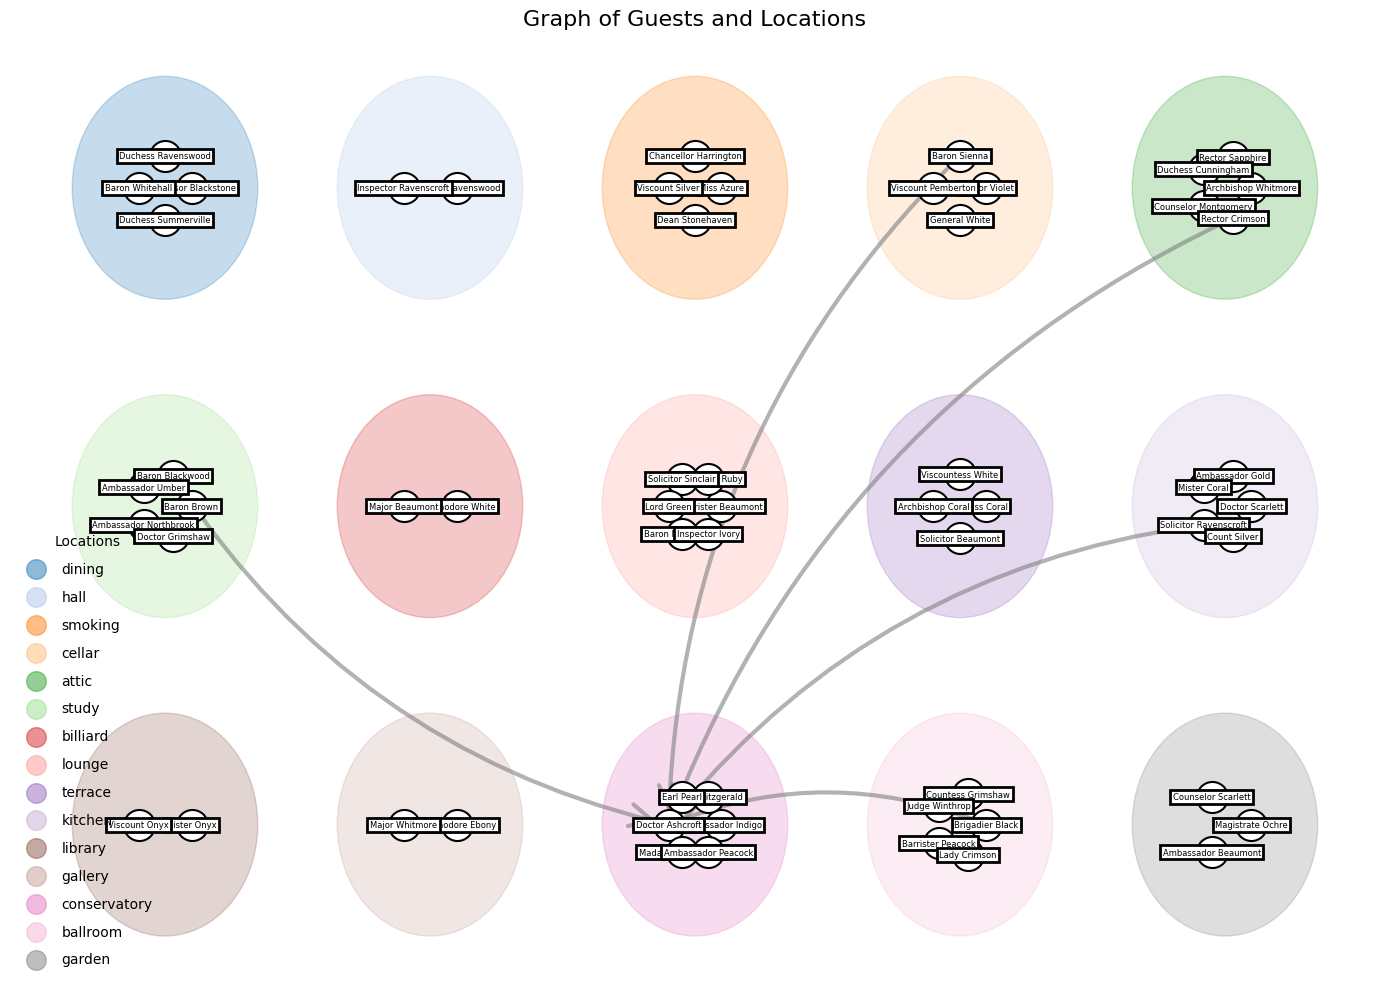

In [15]:
import json
import re

with open('dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)


locations = data['metadata']['locations']
locations = [loc.split()[0] for loc in locations]


interview_texts = {
    entry['guest']: entry['statement']
    for entry in data['interrogations']
}


guest_locations = {}
for guest, stmt in interview_texts.items():
    tokens = re.findall(r"\b[\w']+\b", stmt.lower())
    found = None
    for word in tokens:
        for loc in locations:
            if word == loc.lower():
                found = loc
                break
        if found:
            break
    guest_locations[guest] = found

sightings = {}
all_guests = list(interview_texts.keys())
for guest, stmt in interview_texts.items():
    seen_list = []
    for other in all_guests:
        if other == guest:
            continue
        if other.lower() in stmt.lower() and other == "Doctor Ashcroft":
            seen_list.append(other)
    sightings[guest] = seen_list

G = nx.DiGraph()
for guest, loc in guest_locations.items():
    G.add_node(guest, location=loc)

for viewer, seen_list in sightings.items():
    for seen in seen_list:
        if seen in G:
            G.add_edge(viewer, seen)

unique_locations = list(set(guest_locations.values()))
scale = 2
location_positions = {loc: (scale * (i % 5), -scale * (i // 5)) for i, loc in enumerate(unique_locations)}
color_map = {loc: plt.cm.tab20(i) for i, loc in enumerate(unique_locations)}

pos = {}
for loc in unique_locations:
    guests_in_loc = [g for g, l in guest_locations.items() if l == loc]
    center = np.array(location_positions[loc])
    angle_step = 2 * np.pi / max(1, len(guests_in_loc))
    radius = 0.2
    for i, guest in enumerate(guests_in_loc):
        angle = i * angle_step
        offset = radius * np.array([np.cos(angle), np.sin(angle)])
        pos[guest] = center + offset

plt.figure(figsize=(14, 10))


for loc, center in location_positions.items():
    guests = [g for g, l in guest_locations.items() if l == loc]
    radius = 0.2 + 0.1 * 5
    circle = Circle(center, radius, color=color_map[loc], alpha=0.25, zorder=0)
    plt.gca().add_patch(circle)


nx.draw_networkx_nodes(G, pos, node_color='white', node_size=500, edgecolors='black', linewidths=1.5)
nx.draw_networkx_edges(G, pos, connectionstyle='arc3,rad=0.2', width=3, arrowstyle='->', arrowsize=40, edge_color='gray', alpha=0.6)
nx.draw_networkx_labels(G, pos, font_color='black', font_size=6, bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=2))


for loc, color in color_map.items():
    plt.scatter([], [], c=[color], alpha=0.5, s=200, label=loc)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title="Locations")

plt.title("Graph of Guests and Locations", fontsize=16)
plt.axis('off')
plt.tight_layout()
plt.show()

What becomes immediately apparent from this subgraph is that every guest who mentioned Doctor Ashcroft did so in a vague or incidental manner. There are no strong or mutual confirmations of interaction, only brief sightings or passive mentions. Even more telling is the fact that Doctor Ashcroft, in his own statement, fails to recall or name a single guest that he encountered. This one-sided visibility, combined with his linguistic similarity to the victim’s note, paints a highly suspicious picture and undermines the credibility of his alibi.

🧩 5. Community Detection with Louvain Method

To uncover latent structural groupings among the guests, we applied community detection using the Louvain algorithm. This method clusters nodes based on the density of their connections, optimizing modularity to detect cohesive communities within a network. In our context, guests are represented as nodes, and undirected edges connect any two guests who mention each other in their statements—indicating a perceived or reported interaction.

The graph generated from this co-mention network was passed to the Louvain algorithm using the python-louvain implementation. The result was a partitioning of the guest network into two distinct communities: a large, densely connected cluster and a much smaller, loosely connected one.

This division is both expected and revealing. The larger community contains guests whose alibis appear mutually consistent; their statements reference one another, forming a web of reciprocal sightings that reinforces their collective credibility. In contrast, the smaller community consists of individuals who are only weakly integrated into the network. These guests either mentioned very few others or were themselves mentioned infrequently—often without mutual confirmation.

Crucially, Doctor Ashcroft falls into this smaller, peripheral community. This aligns with earlier observations: although several guests mention seeing him, their statements lack specificity, and he himself fails to name anyone he saw.

Communities:
  - Comm_0: ['Professor Blackstone', 'Mister Fitzgerald', 'Doctor Scarlett', 'Miss Azure', 'Rector Violet', 'Barrister Beaumont', 'Commodore Ebony', 'Ambassador Gold', 'Mister Onyx', 'Countess Grimshaw', 'Archbishop Whitmore', 'Rector Sapphire', 'Solicitor Sinclair', 'Viscount Pemberton', 'Judge Winthrop', 'Lord Green', 'Baron Nightingale', 'Solicitor Ravenscroft', 'Solicitor Beaumont', 'Lady Crimson', 'Doctor Grimshaw', 'Duchess Summerville']
  - Comm_1: ['Ambassador Indigo', 'Baron Brown', 'Commodore White', 'Magistrate Ochre', 'Baron Blackwood', 'Counselor Scarlett', 'Baron Sienna', 'Magistrate Ruby', 'Colonel Ravenswood', 'Major Beaumont', 'Earl Pearl', 'Duchess Ravenswood', 'Brigadier Black', 'Miss Coral', 'Chancellor Harrington', 'Doctor Ashcroft', 'Madame Northbrook', 'Viscountess White', 'General White', 'Baron Whitehall', 'Mister Coral', 'Ambassador Umber', 'Viscount Silver', 'Viscount Onyx', 'Duchess Cunningham', 'Ambassador Beaumont', 'Barrister Peacock', 'Couns

/var/folders/gj/gmsvyb2j4mb68dqn3c3mhq6m0000gn/T/ipykernel_55890/1535132204.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')


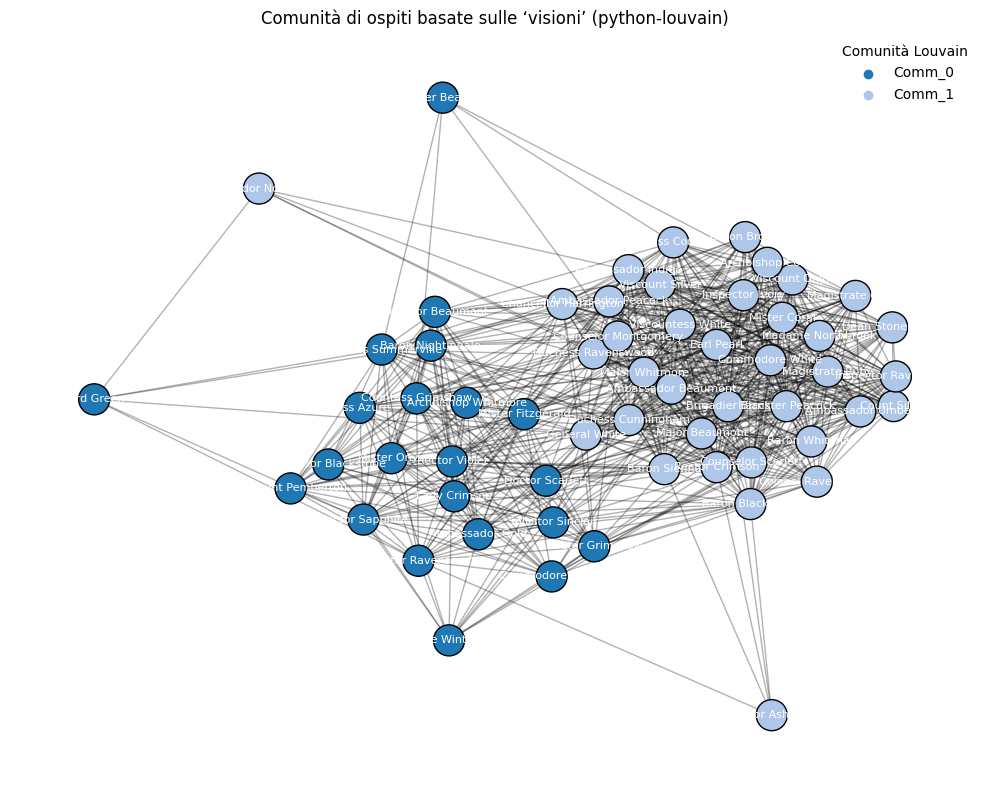

In [16]:
import json
import re
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

with open('dataset.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

locations = data['metadata']['locations']
locations = [loc.split()[0] for loc in locations]


interview_texts = {
    entry['guest']: entry['statement']
    for entry in data['interrogations']
}


guest_locations = {}
for guest, stmt in interview_texts.items():

    tokens = re.findall(r"\b[\w']+\b", stmt.lower())
    found = None
    for word in tokens:
        for loc in locations:
            if word == loc.lower():
                found = loc
                break
        if found:
            break
    guest_locations[guest] = found

sightings = {}
all_guests = list(interview_texts.keys())
for guest, stmt in interview_texts.items():
    seen_list = []
    for other in all_guests:
        if other == guest:
            continue
        if other.lower() in stmt.lower():
            seen_list.append(other)
    sightings[guest] = seen_list

G = nx.Graph()
G.add_nodes_from(all_guests)

for a, seen in sightings.items():
    for b in seen:
        G.add_edge(a, b)

partition = community_louvain.best_partition(G)

from collections import defaultdict

communities = defaultdict(list)
for guest, comm_id in partition.items():
    communities[comm_id].append(guest)

print("Communities:")
for comm_id, members in communities.items():
    print(f"  - Comm_{comm_id}: {members}")


pos = nx.spring_layout(G, seed=42)

cmap = plt.cm.get_cmap('tab20')
node_colors = [cmap(partition[node] % cmap.N) for node in G.nodes()]

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_nodes(G, pos,
                       node_color=node_colors,
                       node_size=500,
                       edgecolors='black')
nx.draw_networkx_labels(G, pos, font_color='white', font_size=8)


for comm_id, members in communities.items():
    plt.scatter([], [], c=[cmap(comm_id % cmap.N)], label=f"Comm_{comm_id}")
plt.legend(scatterpoints=1, frameon=False, title="Comunità Louvain")
plt.title("Comunità di ospiti basate sulle ‘visioni’ (python-louvain)")
plt.axis('off')
plt.tight_layout()
plt.show()

# 5. Conclusions

All strands of the analysis converge on a single suspect: Doctor Ashcroft. His statement shows the highest linguistic similarity to the victim’s note, yet his testimony lacks any concrete mention of other guests. While several claim to have seen him, none report meaningful interaction.